In [1]:
import warnings
from typing import Any
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score, auc
from sklearn.feature_selection import RFECV
import optuna
import optuna.trial
import optuna.logging

from utils import plot_roc
import ml_utils as utils
from ml_utils import (
    get_weights_for_roc_auc, weighted_roc_metric, weighted_fpr_roc_metric, 
    get_optimal_trs, plot_roc, get_tpr_fpr, plot_roc_curves
)
import train


np.random.seed(42)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# aft, magn > 6.0

## read 

In [2]:
dataset_type_train = "magn_6_aft"
dataset_type_test = "magn_6_aft_test"

target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

train_path = f"data/dataset/{dataset_type_train}.parquet"
test_path = f"data/dataset/{dataset_type_test}.parquet"

In [3]:
train_df, test_df = utils.get_train_test_datasets(
    train_path=train_path, test_path=test_path, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

train_path: data/dataset/magn_6_aft.parquet
test_path: data/dataset/magn_6_aft_test.parquet


train dates: 2014-03-20 — 2020-08-25
test dates: 2020-10-14 — 2023-05-21

train: target==0: 2326760, target==1: 200
test: target==0: 9366239, target==1: 761
target class proportion: test: 8.124926130968898e-05, train: 8.595643727758772e-05


In [4]:
feature_cols = list(set(train_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

In [5]:
# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_train, y_train = features.make_features_target(train_df)
X_test, y_test = features.make_features_target(test_df)

In [6]:
y_test.reset_index().merge(y_train.reset_index(), how="left").isna().sum()

dt        0
cell_x    0
cell_y    0
target    0
dtype: int64

In [7]:
# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date)
roc_auc_weights_train = get_weights_for_roc_auc(y=y_train, last_dt=min_test_date)

In [8]:
assert len(roc_auc_weights_test) == len(roc_auc_weights_test[~np.isnan(roc_auc_weights_test)]) == len(y_test)
assert len(roc_auc_weights_train) == len(roc_auc_weights_train[~np.isnan(roc_auc_weights_train)]) == len(y_train)

In [9]:
roc_auc_weights_test

array([0.00721154, 0.00721154, 0.00721154, ..., 0.00240385, 0.00240385,
       0.00240385])

In [10]:
len(roc_auc_weights_test[roc_auc_weights_test > 0.0]), np.max(roc_auc_weights_test), np.unique(roc_auc_weights_test)

(9367000,
 1.0,
 array([0.00240385, 0.00480769, 0.00721154, 0.00961538, 0.01201923,
        0.01442308, 0.01682692, 0.01923077, 0.02163462, 0.02403846,
        0.02644231, 0.02884615, 0.03125   , 0.03365385, 0.03605769,
        0.03846154, 0.04086538, 0.04326923, 0.04567308, 0.04807692,
        0.05048077, 0.05288462, 0.05528846, 0.05769231, 0.06009615,
        0.0625    , 0.06490385, 0.06730769, 0.06971154, 0.07211538,
        0.07451923, 0.07692308, 0.07932692, 0.08173077, 0.08413462,
        0.08653846, 0.08894231, 0.09134615, 0.09375   , 0.09615385,
        0.09855769, 0.10096154, 0.10336538, 0.10576923, 0.10817308,
        0.11057692, 0.11298077, 0.11538462, 0.11778846, 0.12019231,
        0.12259615, 0.125     , 0.12740385, 0.12980769, 0.13221154,
        0.13461538, 0.13701923, 0.13942308, 0.14182692, 0.14423077,
        0.14663462, 0.14903846, 0.15144231, 0.15384615, 0.15625   ,
        0.15865385, 0.16105769, 0.16346154, 0.16586538, 0.16826923,
        0.17067308, 0.17307692, 

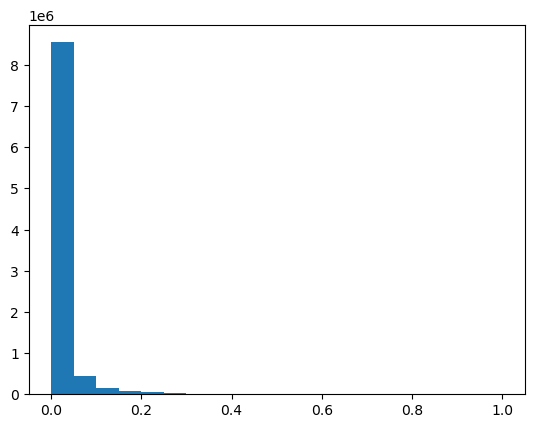

In [11]:
plt.hist(roc_auc_weights_test[roc_auc_weights_test > 0.0], range=(0, 1.0), bins=20);

In [12]:
y_train = y_train[target]
y_test = y_test[target]

In [13]:
y_train.sum(), y_test.sum()

(200, 761)

## logreg

In [14]:
cv = utils.MonthlyTimeSeriesSplit(window=20)
cv.get_n_splits(X_train)

3

In [15]:
for split_train, split_test in cv.split(X_train):
    train_start = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    train_end = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]
    test_start = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    test_end = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]

    print(f"train: [{train_start}, {train_end}], len: {len(split_train)} | test: [{test_start}, {test_end}], len: {len(split_test)}")

train: [2014-03-20, 2015-10-31], len: 591600 | test: [2015-11-10, 2017-06-22], len: 591600
train: [2014-03-20, 2017-06-22], len: 1183200 | test: [2017-07-02, 2019-02-22], len: 601460
train: [2014-03-20, 2019-02-22], len: 1784660 | test: [2019-03-04, 2020-08-25], len: 542300


### baseline

In [17]:
params = {
    "C": 1e-4,
    "max_iter": 100,
    "random_state": 42
}

logreg_model = train.get_logreg_model(feature_cols, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)

baseline_roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

(0.7326057736938919, 0.7550214184359954)

### l1 feature selection

In [16]:
params = {
    "C": 0.1,
    "max_iter": 100,
    "penalty": "l1",
    "solver": "liblinear",
}

logreg_model = train.get_logreg_model(feature_cols, params)
logreg_model.fit(X_train, y_train)

y_pred_prob = logreg_model.predict_proba(X_test)
(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(0.852051872560986, 0.6477586179707127)

In [17]:
coefficients = logreg_model["logisticregression"].coef_[0]

In [24]:
len(coefficients[coefficients == 0.0])

305

In [27]:
len(coefficients[~(coefficients == 0.0)])

67

In [29]:
coefficients[~(coefficients == 0.0)]

array([ 2.55885866e-03,  5.95607868e-02, -3.17507378e-01,  1.29813950e-01,
        2.09156020e-01,  6.34060579e-02, -1.87284538e-02, -4.10279360e-02,
        3.19395913e-01, -3.08930502e-01, -1.43601836e-01, -3.83777957e-02,
       -6.24686979e-04, -2.17228714e-02,  4.62878606e-02, -2.00632751e-02,
        7.74023701e-02,  2.17878813e-01, -2.86274726e-01,  1.75814611e-01,
       -3.84685387e-02, -3.76045156e-04, -1.09158551e-01, -2.51954216e-02,
        8.41507213e-02, -1.00935726e-01, -8.72508726e-02, -5.50317599e-02,
       -7.98514364e-02, -2.25627404e-02,  1.06846141e-01, -1.53822687e-02,
       -2.30992653e-01, -3.37525376e-05, -1.82272634e-01, -6.31172632e-03,
        1.16870515e-03,  5.29493421e-02,  1.54444180e-01, -4.84674285e-02,
        2.31930393e-01,  2.34419033e-01, -7.61561636e-02, -3.17654258e-01,
        3.29224379e-03,  2.16892038e-02,  1.72181534e-01,  1.61904781e-01,
        1.36872587e-02,  1.58203994e-01,  1.37523737e-01, -5.39269988e-02,
       -3.21953360e-01, -

In [33]:
l1_features = X_test.columns[~(coefficients == 0)].tolist()

In [34]:
print(len(l1_features))

l1_features

67


['cell_y',
 'min_magn_m6.0_3650_rad0',
 'std_magn_m6.0_1095_rad3',
 'std_magn_m4.0_60_rad5',
 'max_magn_m4.0_90_rad5',
 'count_earthquakes_m4.0_90_rad5',
 'std_magn_m6.0_365_rad5',
 'dt_year',
 'count_earthquakes_m6.0_1095_rad5',
 'std_magn_m6.0_3650_rad5',
 'min_magn_m6.0_1095_rad0',
 'min_magn_m4.0_2555_rad3',
 'min_magn_m4.0_1095_rad5',
 'min_magn_m6.0_60_rad3',
 'count_earthquakes_m6.0_3650_rad3',
 'std_magn_m6.0_2555_rad3',
 'min_magn_m4.0_180_rad3',
 'min_magn_m4.0_365_rad3',
 'count_earthquakes_m6.0_2555_rad0',
 'min_magn_m4.0_3650_rad5',
 'std_magn_m4.0_365_rad3',
 'mean_magn_m6.0_180_rad0',
 'std_magn_m4.0_180_rad0',
 'count_earthquakes_m6.0_90_rad5',
 'count_earthquakes_m4.0_365_rad3',
 'std_magn_m6.0_3650_rad3',
 'count_earthquakes_m4.0_2555_rad3',
 'std_magn_m4.0_365_rad0',
 'std_magn_m4.0_2555_rad5',
 'count_earthquakes_m6.0_365_rad5',
 'std_magn_m4.0_90_rad5',
 'std_magn_m6.0_3650_rad0',
 'mean_magn_m4.0_1095_rad5',
 'min_magn_m6.0_180_rad0',
 'std_magn_m4.0_1095_rad5',
 

In [16]:
l1_features = [
    'cell_y',
    'min_magn_m6.0_3650_rad0',
    'std_magn_m6.0_1095_rad3',
    'std_magn_m4.0_60_rad5',
    'max_magn_m4.0_90_rad5',
    'count_earthquakes_m4.0_90_rad5',
    'std_magn_m6.0_365_rad5',
    'dt_year',
    'count_earthquakes_m6.0_1095_rad5',
    'std_magn_m6.0_3650_rad5',
    'min_magn_m6.0_1095_rad0',
    'min_magn_m4.0_2555_rad3',
    'min_magn_m4.0_1095_rad5',
    'min_magn_m6.0_60_rad3',
    'count_earthquakes_m6.0_3650_rad3',
    'std_magn_m6.0_2555_rad3',
    'min_magn_m4.0_180_rad3',
    'min_magn_m4.0_365_rad3',
    'count_earthquakes_m6.0_2555_rad0',
    'min_magn_m4.0_3650_rad5',
    'std_magn_m4.0_365_rad3',
    'mean_magn_m6.0_180_rad0',
    'std_magn_m4.0_180_rad0',
    'count_earthquakes_m6.0_90_rad5',
    'count_earthquakes_m4.0_365_rad3',
    'std_magn_m6.0_3650_rad3',
    'count_earthquakes_m4.0_2555_rad3',
    'std_magn_m4.0_365_rad0',
    'std_magn_m4.0_2555_rad5',
    'count_earthquakes_m6.0_365_rad5',
    'std_magn_m4.0_90_rad5',
    'std_magn_m6.0_3650_rad0',
    'mean_magn_m4.0_1095_rad5',
    'min_magn_m6.0_180_rad0',
    'std_magn_m4.0_1095_rad5',
    'max_magn_m6.0_180_rad0',
    'count_earthquakes_m4.0_60_rad5',
    'min_magn_m6.0_1825_rad5',
    'min_magn_m6.0_2555_rad3',
    'count_earthquakes_m4.0_1095_rad5',
    'std_magn_m4.0_3650_rad0',
    'min_magn_m4.0_1095_rad0',
    'day_of_year',
    'max_magn_m6.0_365_rad5',
    'lat_cell',
    'count_earthquakes_m6.0_1825_rad5',
    'min_magn_m6.0_180_rad3',
    'std_magn_m4.0_2555_rad0',
    'count_earthquakes_m4.0_365_rad0',
    'std_magn_m4.0_1825_rad3',
    'min_magn_m4.0_2555_rad0',
    'std_magn_m6.0_90_rad5',
    'min_magn_m4.0_365_rad5',
    'std_magn_m4.0_90_rad3',
    'std_magn_m4.0_180_rad5',
    'std_magn_m4.0_3650_rad5',
    'std_magn_m6.0_1825_rad5',
    'min_magn_m4.0_180_rad0',
    'mean_magn_m6.0_1825_rad0',
    'day_of_year_cos',
    'count_earthquakes_m4.0_2555_rad0',
    'min_magn_m6.0_1825_rad0',
    'std_magn_m4.0_1825_rad0',
    'count_earthquakes_m6.0_1095_rad3',
    'min_magn_m4.0_60_rad0',
    'count_earthquakes_m4.0_1825_rad0',
    'std_magn_m6.0_1095_rad5'
]

In [17]:
params = {
    "C": 1e-4,
    "max_iter": 100,
    "random_state": 42
}

logreg_model = train.get_logreg_model(l1_features, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)

(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

(0.7435788843714005, 0.7612303565338079)

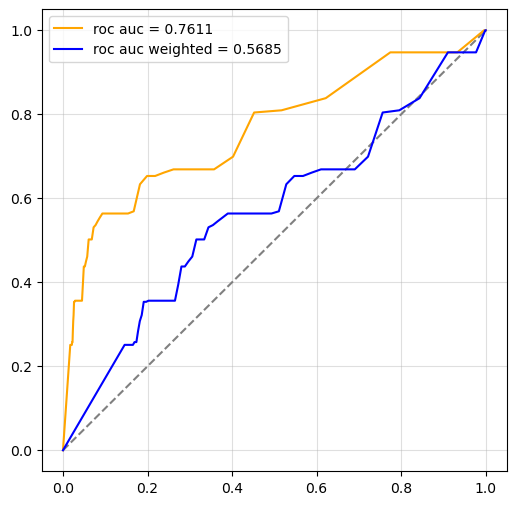

In [69]:
plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

### hyper optimiziation

In [26]:
def fixed_params(**kwargs) -> dict[str, Any]:
    params = {
        "max_iter": 100,
        "penalty": "l2",
        "random_state": 42,
    }

    params.update(kwargs)

    return params


def default_params(**kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": 1e-4,
    }
    params.update(kwargs)

    return params


def suggest_params(trial: optuna.trial.Trial, **kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": trial.suggest_float("C", 1e-5, 1e-4),
    }
    params.update(kwargs)

    return params

tuned_logreg = train.run_optuna(
    X = X_train,
    y = y_train,
    n_trials = 100,
    dump_study_path = f"data/optuna_res/logreg_{dataset_type_train.replace('_train', '')}",
    seed = 42,
    resume = False,
    suggest_params = suggest_params,
    default_params = default_params,
    cv = utils.MonthlyTimeSeriesSplit(window=20, partition=True),
    model = train.get_logreg_model(l1_features, default_params()),
    n_jobs = 40,
    model_name = "logisticregression",
)

using MonthlyTimeSeriesSplit


logisticregression hyperoptimisation: 100%|██████████| 100/100 [43:23<00:00, 26.04s/it]


In [27]:
tuned_logreg_params = tuned_logreg["logisticregression"].get_params()
tuned_logreg_params

{'C': 9.995834808845237e-05,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


100%|██████████| 102/102 [01:48<00:00,  1.07s/it]
                                                 
100%|██████████| 102/102 [03:34<00:00,  2.11s/it]
                                                 

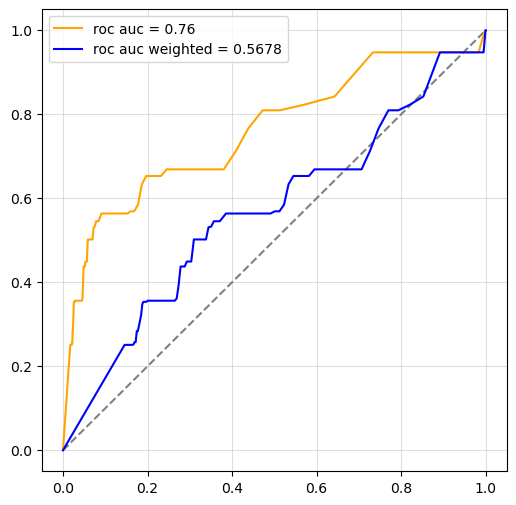

In [28]:
reulst_aft_logreg = tuned_logreg.fit(X_train, y_train)
y_pred_prob = reulst_aft_logreg.predict_proba(X_test)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

In [29]:
(
    roc_auc_score(y_train, reulst_aft_logreg.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.7435719476869124, 0.7612301564694918)

In [30]:
! rm -rf data/models/aft_6_logreg_.pickle

In [31]:
joblib.dump(reulst_aft_logreg, "data/models/aft_6_logreg_.pickle")

['data/models/aft_6_logreg_.pickle']

# withoutaft, magn > 6.0

## read 

In [32]:
dataset_type_train = "magn_6_withoutaft"
dataset_type_test = "magn_6_withoutaft_test"

target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

train_path = f"data/dataset/{dataset_type_train}.parquet"
test_path = f"data/dataset/{dataset_type_test}.parquet"

In [33]:
train_df, test_df = utils.get_train_test_datasets(
    train_path=train_path, test_path=test_path, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

train_path: data/dataset/magn_6_withoutaft.parquet
test_path: data/dataset/magn_6_withoutaft_test.parquet


train dates: 2014-03-20 — 2020-08-25
test dates: 2020-10-14 — 2023-05-09

train: target==0: 1878932, target==1: 100
test: target==0: 95163, target==1: 513
target class proportion: test: 0.005390750606853504, train: 5.3221723830346177e-05


In [34]:
feature_cols = list(set(train_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

In [35]:
# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_train, y_train = features.make_features_target(train_df)
X_test, y_test = features.make_features_target(test_df)

In [36]:
y_test.reset_index().merge(y_train.reset_index(), how="left").isna().sum()

dt        0
cell_x    0
cell_y    0
target    0
dtype: int64

In [37]:
# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date)
roc_auc_weights_train = get_weights_for_roc_auc(y=y_train, last_dt=min_test_date)

In [38]:
assert len(roc_auc_weights_test) == len(roc_auc_weights_test[~np.isnan(roc_auc_weights_test)]) == len(y_test)
assert len(roc_auc_weights_train) == len(roc_auc_weights_train[~np.isnan(roc_auc_weights_train)]) == len(y_train)

In [39]:
len(roc_auc_weights_test[roc_auc_weights_test > 0.0]), np.max(roc_auc_weights_test), np.unique(roc_auc_weights_test)

(95676,
 0.6418269230769231,
 array([0.00240385, 0.00480769, 0.00721154, 0.00961538, 0.01201923,
        0.01442308, 0.01682692, 0.01923077, 0.02163462, 0.02403846,
        0.02644231, 0.02884615, 0.03125   , 0.03365385, 0.03605769,
        0.03846154, 0.04326923, 0.04567308, 0.04807692, 0.05048077,
        0.05288462, 0.05528846, 0.06490385, 0.06730769, 0.06971154,
        0.07211538, 0.07451923, 0.07932692, 0.08413462, 0.09134615,
        0.09615385, 0.09855769, 0.10096154, 0.10576923, 0.10817308,
        0.11298077, 0.11538462, 0.11778846, 0.13701923, 0.14423077,
        0.17067308, 0.20192308, 0.20673077, 0.20913462, 0.21394231,
        0.24278846, 0.27644231, 0.30048077, 0.33894231, 0.35336538,
        0.37019231, 0.37259615, 0.41105769, 0.64182692]))

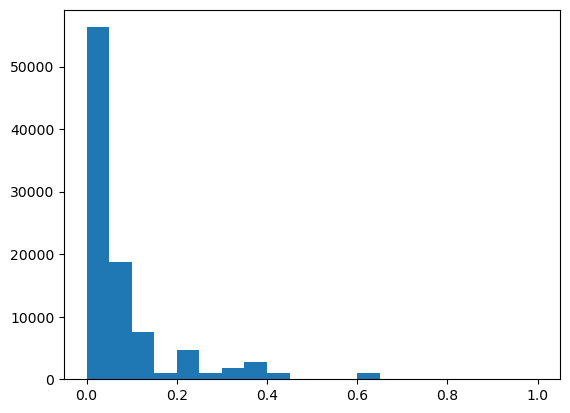

In [40]:
plt.hist(roc_auc_weights_test[roc_auc_weights_test > 0.0], range=(0, 1.0), bins=20);

In [41]:
y_train = y_train[target]
y_test = y_test[target]

In [42]:
y_train.sum(), y_test.sum()

(100, 513)

## logreg

In [43]:
cv = utils.MonthlyTimeSeriesSplit(window=20)
cv.get_n_splits(X_train)

3

In [44]:
for split_train, split_test in cv.split(X_train):
    train_start = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    train_end = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]
    test_start = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    test_end = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]

    print(f"train: [{train_start}, {train_end}], len: {len(split_train)} | test: [{test_start}, {test_end}], len: {len(split_test)}")

train: [2014-03-20, 2015-10-31], len: 477720 | test: [2015-11-10, 2017-06-22], len: 477720
train: [2014-03-20, 2017-06-22], len: 955440 | test: [2017-07-02, 2019-02-22], len: 485682
train: [2014-03-20, 2019-02-22], len: 1441122 | test: [2019-03-04, 2020-08-25], len: 437910


### baseline

In [165]:
params = {
    "C": 1e-3,
    "max_iter": 100,
    "random_state": 42,
}

logreg_model = train.get_logreg_model(feature_cols, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)

(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

(0.7911226750089945, 0.5696786097124131)


 95%|█████████▍| 191/202 [00:01<00:00, 112.75it/s]
                                                  
 98%|█████████▊| 197/202 [00:02<00:00, 78.08it/s]
                                                 

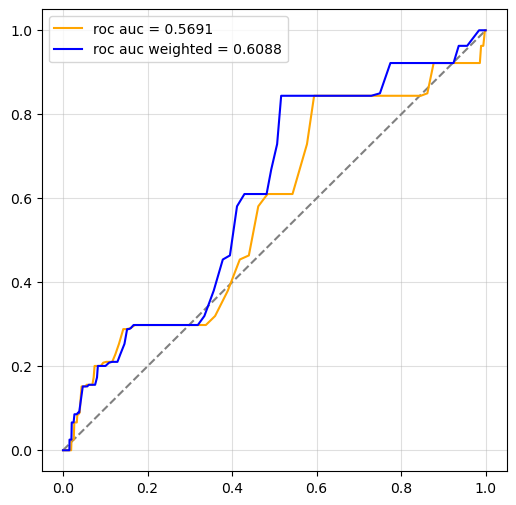

In [166]:
plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=200)

### l1 feature selection

In [167]:
params = {
    "C": 0.75,
    "max_iter": 100,
    "penalty": "l1",
    "solver": "liblinear",
    "random_state": 42,
}

logreg_model = train.get_logreg_model(feature_cols, params)
logreg_model.fit(X_train, y_train)

y_pred_prob = logreg_model.predict_proba(X_test)
(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

(0.920134416785706, 0.5554687239309247)

In [168]:
len(feature_cols)

372

In [169]:
coefficients = logreg_model["logisticregression"].coef_[0]

In [170]:
len(coefficients[(coefficients == 0.0)])

290

In [171]:
len(coefficients[~(coefficients == 0.0)])

82

In [172]:
coefficients[~(coefficients == 0.0)]

array([ 0.38814637, -0.2114189 , -0.2054927 , -0.32248419,  0.31176818,
       -0.4187531 , -0.46304283, -0.01065271,  0.19451342,  0.34514848,
        0.22132787,  0.01694492,  0.22089793,  0.58033438,  0.06502425,
        0.17337258, -0.37978679,  0.1196997 ,  0.14402938,  0.98048778,
        0.76529774, -0.42132296, -0.38057974, -1.48187694, -0.05256138,
       -0.15751763, -0.57307577, -0.08878469,  0.38856517, -0.15020596,
       -0.14768785,  0.84893736,  0.19168429,  0.53808594, -0.46459031,
        0.12499047, -0.2798497 ,  0.17160041, -0.15394116, -0.55518076,
       -0.1021517 ,  0.01085089,  0.21127624, -0.098618  , -0.12306707,
       -0.50385627, -0.06434036, -0.2720487 , -0.4133375 ,  0.00991084,
        0.33771624, -0.19188835,  0.2831779 , -0.11172647,  0.22880086,
       -0.36397597,  0.26963428, -0.08092598,  0.69300126, -0.45029774,
        0.02867241,  0.49823397, -0.76066177, -0.05058677, -0.34586643,
        0.47460033,  0.67309691, -0.17447811,  0.01321336,  0.34

In [173]:
l1_features = X_test.columns[~(coefficients == 0)].tolist()

In [174]:
print(len(l1_features))

l1_features

82


['count_earthquakes_m4.0_3650_rad3',
 'std_magn_m4.0_1095_rad0',
 'std_magn_m4.0_180_rad3',
 'count_earthquakes_m4.0_1095_rad0',
 'count_earthquakes_m4.0_1095_rad3',
 'max_magn_m4.0_60_rad3',
 'count_earthquakes_m4.0_3650_rad5',
 'count_earthquakes_m4.0_1095_rad5',
 'cell_y',
 'count_earthquakes_m6.0_60_rad3',
 'min_magn_m4.0_180_rad0',
 'count_earthquakes_m4.0_180_rad5',
 'count_earthquakes_m4.0_60_rad5',
 'min_magn_m6.0_2555_rad5',
 'mean_magn_m4.0_180_rad0',
 'mean_magn_m4.0_1825_rad3',
 'min_magn_m4.0_3650_rad3',
 'std_magn_m4.0_60_rad5',
 'mean_magn_m4.0_90_rad3',
 'count_earthquakes_m4.0_1825_rad0',
 'min_magn_m4.0_1095_rad0',
 'count_earthquakes_m6.0_3650_rad5',
 'std_magn_m4.0_3650_rad0',
 'max_magn_m4.0_1825_rad0',
 'count_earthquakes_m4.0_90_rad5',
 'std_magn_m4.0_1825_rad3',
 'std_magn_m4.0_2555_rad3',
 'std_magn_m6.0_3650_rad3',
 'std_magn_m4.0_180_rad5',
 'count_earthquakes_m6.0_365_rad5',
 'max_magn_m6.0_365_rad5',
 'std_magn_m4.0_1095_rad3',
 'count_earthquakes_m4.0_60_r

In [181]:
params = {
    "C": 2e-4,
    "max_iter": 100,
    "random_state": 42
}

logreg_model = train.get_logreg_model(l1_features, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)

(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

(0.6631088724871363, 0.565377955488663)


 95%|█████████▌| 192/202 [00:01<00:00, 155.28it/s]
                                                  
 99%|█████████▉| 200/202 [00:02<00:00, 78.18it/s]
                                                 

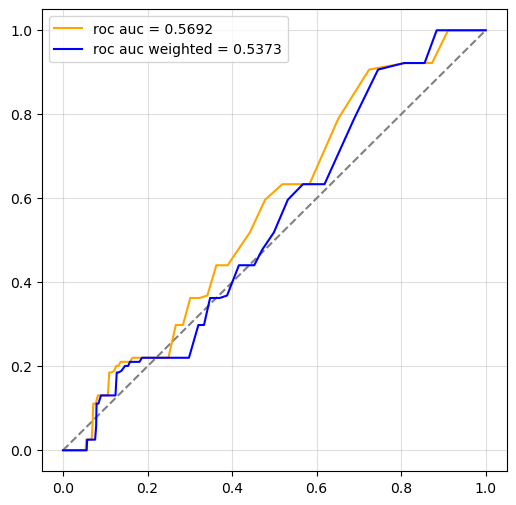

In [182]:
plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=200)

### hyper optimiziation

In [183]:
def fixed_params(**kwargs) -> dict[str, Any]:
    params = {
        "max_iter": 100,
        "penalty": "l2",
        "random_state": 42,
    }

    params.update(kwargs)

    return params


def default_params(**kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": 1e-4,
    }
    params.update(kwargs)

    return params


def suggest_params(trial: optuna.trial.Trial, **kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": trial.suggest_float("C", 1e-6, 1e-3),
    }
    params.update(kwargs)

    return params

tuned_logreg = train.run_optuna(
    X = X_train,
    y = y_train,
    n_trials = 100,
    dump_study_path = f"data/optuna_res/logreg_{dataset_type_train.replace('_train', '')}",
    seed = 42,
    resume = False,
    suggest_params = suggest_params,
    default_params = default_params,
    cv = utils.MonthlyTimeSeriesSplit(window=20, partition=True),
    model = train.get_logreg_model(l1_features, default_params()),
    n_jobs = 40,
    model_name = "logisticregression",
)

using MonthlyTimeSeriesSplit


logisticregression hyperoptimisation: 100%|██████████| 100/100 [39:27<00:00, 23.68s/it]


In [184]:
tuned_logreg_params = tuned_logreg["logisticregression"].get_params()
tuned_logreg_params

{'C': 0.0009115281082715307,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


 89%|████████▉ | 91/102 [00:00<00:00, 149.99it/s]
                                                 
 94%|█████████▍| 96/102 [00:01<00:00, 76.57it/s]
                                                

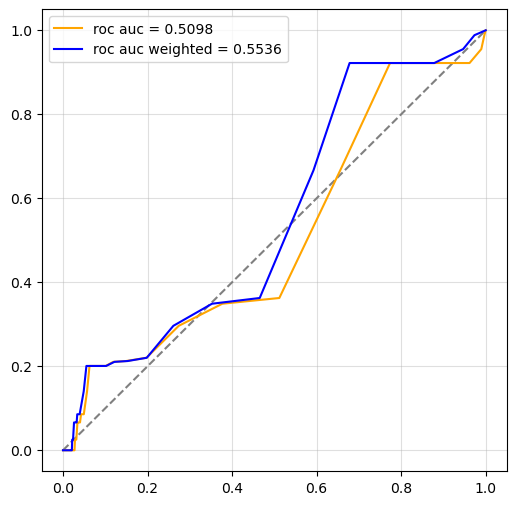

In [185]:
reulst_withoutaft_logreg = tuned_logreg.fit(X_train, y_train)
y_pred_prob = reulst_withoutaft_logreg.predict_proba(X_test)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

In [186]:
(
    roc_auc_score(y_train, reulst_withoutaft_logreg.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.7491106809613122, 0.5098562702070699)

In [187]:
! rm -rf data/models/withoutaft_6_logreg_.pickle

In [ ]:
joblib.dump(reulst_withoutaft_logreg, "data/models/withoutaft_6_logreg.pickle")

['data/models/withoutaft_6_logreg_.pickle']